In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

In [3]:

def add_noise(img,noise_type="gaussian"):
  
  row,col=28,28
  img=img.astype(np.float32)
  
  if noise_type=="gaussian":
    mean=0
    var=10
    sigma=var**.5
    noise=np.random.normal(-5.9,5.9,img.shape)
    noise=noise.reshape(row,col)
    img=img+noise
    return img

  if noise_type=="speckle":
    noise=np.random.randn(row,col)
    noise=noise.reshape(row,col)
    img=img+img*noise
    return img

In [4]:

(xtrain,ytrain),(xtest,ytest)=mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain),len(xtest)))

11493376/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [5]:

noises=["gaussian","speckle"]
noise_ct=0
noise_id=0
traindata=np.zeros((60000,28,28))



for idx in tqdm(range(len(xtrain))):
  
  if noise_ct<(len(xtrain)/2):
    noise_ct+=1
    traindata[idx]=add_noise(xtrain[idx],noise_type=noises[noise_id])
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id])) 




noise_ct=0
noise_id=0
testdata=np.zeros((10000,28,28))

for idx in tqdm(range(len(xtest))):
  
  if noise_ct<(len(xtest)/2):
    noise_ct+=1
    x=add_noise(xtest[idx],noise_type=noises[noise_id])
    testdata[idx]=x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id+=1
    noise_ct=0


print("\n{} noise addition completed to images".format(noises[noise_id]))

 54%|█████▍    | 32617/60000 [00:01<00:01, 20266.90it/s]


gaussian noise addition completed to images


 21%|██        | 2092/10000 [00:00<00:00, 20918.42it/s]


speckle noise addition completed to images


 79%|███████▉  | 7906/10000 [00:00<00:00, 19999.61it/s]


gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 19383.54it/s]


speckle noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

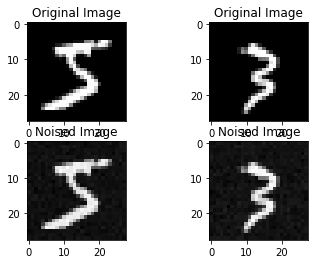

In [6]:


f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0],cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0],cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000],cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000],cmap="gray")
axes[1,1].set_title("Noised Image")

In [7]:
class noisedDataset(Dataset):
  
  def __init__(self,datasetnoised,datasetclean,labels,transform):
    self.noise=datasetnoised
    self.clean=datasetclean
    self.labels=labels
    self.transform=transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self,idx):
    xNoise=self.noise[idx]
    xClean=self.clean[idx]
    y=self.labels[idx]
    
    if self.transform != None:
      xNoise=self.transform(xNoise)
      xClean=self.transform(xClean)
      
    
    return (xNoise,xClean,y)

In [8]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata,xtrain,ytrain,tsfms)
testset=noisedDataset(testdata,xtest,ytest,tsfms)

In [9]:

batch_size=32



trainloader=DataLoader(trainset,batch_size=32,shuffle=True)
testloader=DataLoader(testset,batch_size=1,shuffle=True)

In [10]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder=nn.Sequential(
                  nn.Linear(28*28,256),
                  nn.ReLU(True),
                  nn.Linear(256,128),
                  nn.ReLU(True),
                  nn.Linear(128,64),
                  nn.ReLU(True)
        
                  )
    
    self.decoder=nn.Sequential(
                  nn.Linear(64,128),
                  nn.ReLU(True),
                  nn.Linear(128,256),
                  nn.ReLU(True),
                  nn.Linear(256,28*28),
                  nn.Sigmoid(),
                  )
    
 
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x

In [13]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

  
model=denoising_model().to(device)
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)


epochs=20
l=len(trainloader)
losslist=list()
epochloss=0
running_loss=0
for epoch in range(epochs):
  
  print("Entering Epoch: ",epoch)
  for dirty,clean,label in tqdm((trainloader)):
    
    
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)
    
    
    
    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    epochloss+=loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss=0
  print("======> epoch: {}/{}, Loss:{}".format(epoch,epochs,loss.item()))


  1%|          | 15/1875 [00:00<00:13, 141.05it/s]

Entering Epoch:  0



100%|██████████| 1875/1875 [00:14<00:00, 133.12it/s]

  1%|          | 13/1875 [00:00<00:14, 124.64it/s]

======> epoch: 0/20, Loss:0.07377459853887558
Entering Epoch:  1



100%|██████████| 1875/1875 [00:13<00:00, 140.99it/s]

  1%|          | 13/1875 [00:00<00:14, 129.34it/s]

======> epoch: 1/20, Loss:0.06805142760276794
Entering Epoch:  2



100%|██████████| 1875/1875 [00:13<00:00, 142.54it/s]

  1%|          | 14/1875 [00:00<00:13, 137.30it/s]

======> epoch: 2/20, Loss:0.06842263042926788
Entering Epoch:  3



100%|██████████| 1875/1875 [00:13<00:00, 143.47it/s]

  1%|          | 14/1875 [00:00<00:13, 139.29it/s]

======> epoch: 3/20, Loss:0.0635705292224884
Entering Epoch:  4



100%|██████████| 1875/1875 [00:13<00:00, 137.12it/s]

  1%|          | 13/1875 [00:00<00:14, 124.43it/s]

======> epoch: 4/20, Loss:0.05532657727599144
Entering Epoch:  5



100%|██████████| 1875/1875 [00:13<00:00, 136.22it/s]

  1%|          | 13/1875 [00:00<00:15, 120.63it/s]

======> epoch: 5/20, Loss:0.05521847680211067
Entering Epoch:  6



100%|██████████| 1875/1875 [00:14<00:00, 133.11it/s]

  1%|          | 12/1875 [00:00<00:16, 115.95it/s]

======> epoch: 6/20, Loss:0.0578690841794014
Entering Epoch:  7



100%|██████████| 1875/1875 [00:13<00:00, 138.12it/s]

  1%|          | 14/1875 [00:00<00:13, 138.74it/s]

======> epoch: 7/20, Loss:0.0493999607861042
Entering Epoch:  8



100%|██████████| 1875/1875 [00:13<00:00, 140.13it/s]

  1%|          | 15/1875 [00:00<00:12, 148.58it/s]

======> epoch: 8/20, Loss:0.04929231479763985
Entering Epoch:  9



100%|██████████| 1875/1875 [00:13<00:00, 139.44it/s]

  1%|          | 13/1875 [00:00<00:14, 129.81it/s]

======> epoch: 9/20, Loss:0.04629911109805107
Entering Epoch:  10



100%|██████████| 1875/1875 [00:18<00:00, 99.98it/s] 

  1%|          | 12/1875 [00:00<00:16, 116.18it/s]

======> epoch: 10/20, Loss:0.04879206418991089
Entering Epoch:  11



100%|██████████| 1875/1875 [00:13<00:00, 136.14it/s]

  1%|          | 14/1875 [00:00<00:13, 134.79it/s]

======> epoch: 11/20, Loss:0.0450429767370224
Entering Epoch:  12



100%|██████████| 1875/1875 [00:13<00:00, 135.49it/s]

  1%|          | 14/1875 [00:00<00:14, 131.56it/s]

======> epoch: 12/20, Loss:0.04115285351872444
Entering Epoch:  13



100%|██████████| 1875/1875 [00:13<00:00, 135.85it/s]

  1%|          | 12/1875 [00:00<00:15, 117.28it/s]

======> epoch: 13/20, Loss:0.04314792528748512
Entering Epoch:  14



100%|██████████| 1875/1875 [00:13<00:00, 139.14it/s]

  1%|          | 14/1875 [00:00<00:13, 136.37it/s]

======> epoch: 14/20, Loss:0.04134705662727356
Entering Epoch:  15



100%|██████████| 1875/1875 [00:13<00:00, 135.58it/s]

  1%|          | 13/1875 [00:00<00:14, 128.38it/s]

======> epoch: 15/20, Loss:0.040005702525377274
Entering Epoch:  16



100%|██████████| 1875/1875 [00:14<00:00, 133.44it/s]

  1%|          | 14/1875 [00:00<00:14, 130.82it/s]

======> epoch: 16/20, Loss:0.04146479442715645
Entering Epoch:  17



100%|██████████| 1875/1875 [00:13<00:00, 134.27it/s]

  1%|          | 14/1875 [00:00<00:14, 132.13it/s]

======> epoch: 17/20, Loss:0.03991971164941788
Entering Epoch:  18



100%|██████████| 1875/1875 [00:13<00:00, 134.61it/s]

  1%|          | 13/1875 [00:00<00:15, 122.51it/s]

======> epoch: 18/20, Loss:0.04338846728205681
Entering Epoch:  19



100%|██████████| 1875/1875 [00:14<00:00, 133.29it/s]

======> epoch: 19/20, Loss:0.04173903539776802


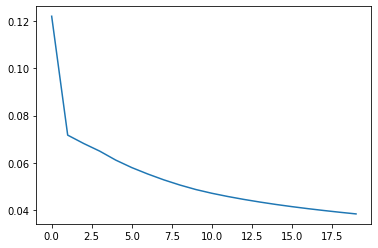

In [14]:
plt.plot(range(len(losslist)),losslist)

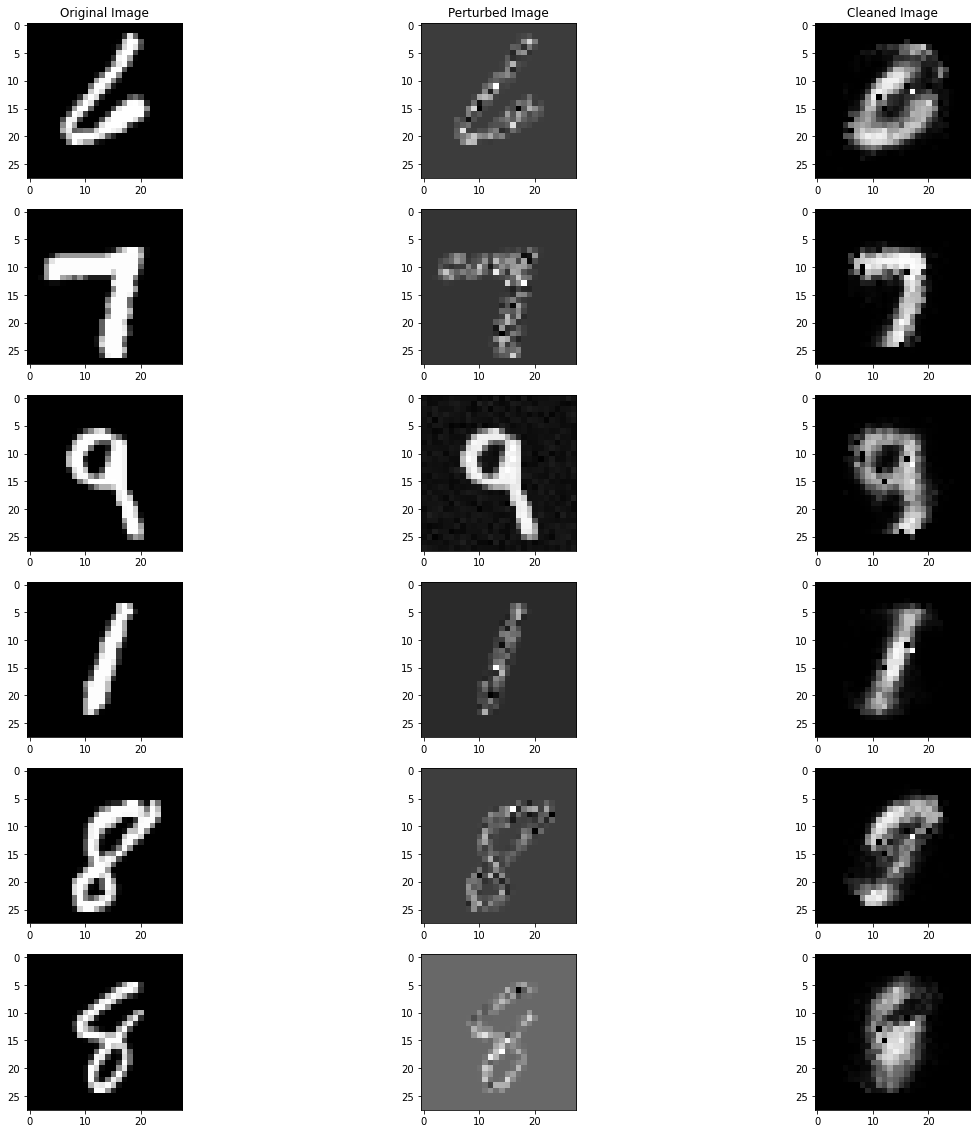

In [17]:


f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Perturbed Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")